<a href="https://colab.research.google.com/github/brunopdrocha/ibmec_computer_vision/blob/main/Ac4_ComputerVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

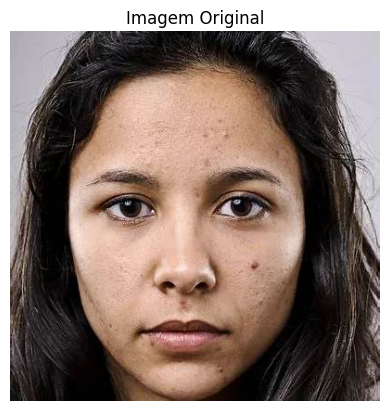

In [43]:
import cv2
from matplotlib import pyplot as plt

# Carrega imagem local
img = cv2.imread('/content/fotoperfilVC.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.title('Imagem Original')
plt.imshow(img_rgb)
plt.axis('off')
plt.show()


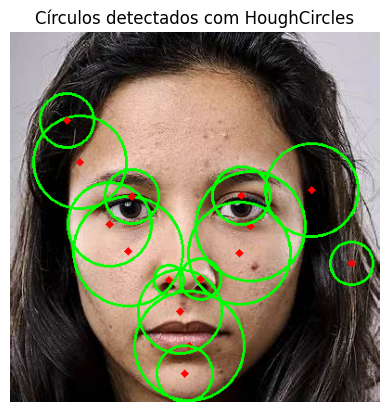

In [44]:
import numpy as np

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.medianBlur(gray, 5)

circles = cv2.HoughCircles(
    gray,
    cv2.HOUGH_GRADIENT,
    dp=1.2,
    minDist=30,
    param1=100,
    param2=30,
    minRadius=10,
    maxRadius=60
)

img_circulos = img.copy()

if circles is not None:
    circles = np.uint16(np.around(circles))
    for (x, y, r) in circles[0, :]:
        cv2.circle(img_circulos, (x, y), r, (0, 255, 0), 2)
        cv2.circle(img_circulos, (x, y), 2, (0, 0, 255), 3)

plt.imshow(cv2.cvtColor(img_circulos, cv2.COLOR_BGR2RGB))
plt.title("Círculos detectados com HoughCircles")
plt.axis('off')
plt.show()


## - Detectar círculo em uma imagem

A detecção de círculos foi realizada utilizando a função `cv2.HoughCircles`, pois utilizando shape number não conseguimos destacar de forma clara.

A função detectou com precisão regiões circulares como olhos, mesmo com iluminação natural e bordas suaves. A substituição foi justificada pela limitação prática da segmentação para o cálculo direto do número de forma.


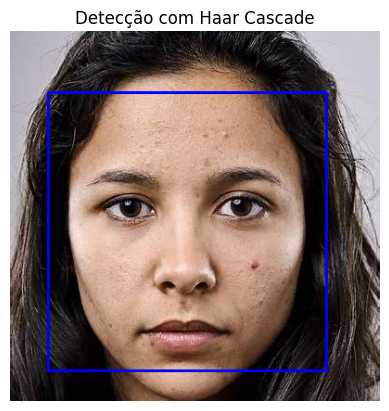

In [45]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.3, 5)

img_haar = img.copy()
for (x, y, w, h) in faces:
    cv2.rectangle(img_haar, (x, y), (x+w, y+h), (255, 0, 0), 2)

plt.imshow(cv2.cvtColor(img_haar, cv2.COLOR_BGR2RGB))
plt.title("Detecção com Haar Cascade")
plt.axis('off')
plt.show()


### - Podemos deixar de usar os dados do arquivo `.xml`?

Não. O arquivo `.xml` contém os pesos e regras aprendidas durante o treinamento do classificador Haar. Ele é essencial para o funcionamento da função `CascadeClassifier`. Sem ele, o OpenCV não consegue realizar a detecção facial, pois o algoritmo não possui um modelo aprendido embutido por padrão.

### - Qual a importância desses dados?

O arquivo `.xml` funciona como o “modelo treinado” do classificador Haar. Ele contém a descrição das features Haar que foram aprendidas a partir de milhares de imagens de rosto. Sem esses dados, o classificador não consegue identificar os padrões visuais característicos de uma face humana.

Esse mesmo conceito se aplica aos arquivos `.caffemodel` e `.prototxt` usados na abordagem com redes neurais (DNN).


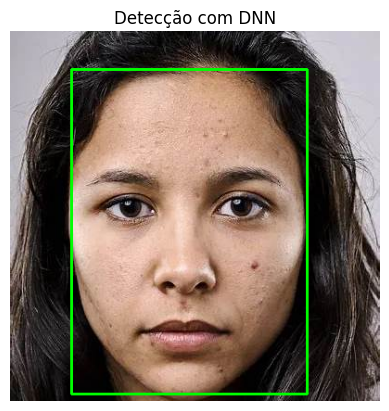

In [46]:
net = cv2.dnn.readNetFromCaffe('/content/deploy.prototxt', '/content/res10_300x300_ssd_iter_140000.caffemodel')

(h, w) = img.shape[:2]
blob = cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)), 1.0,
                             (300, 300), (104.0, 177.0, 123.0))
net.setInput(blob)
detections = net.forward()

img_dnn = img.copy()
for i in range(detections.shape[2]):
    confidence = detections[0, 0, i, 2]
    if confidence > 0.5:
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
        cv2.rectangle(img_dnn, (startX, startY), (endX, endY), (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(img_dnn, cv2.COLOR_BGR2RGB))
plt.title("Detecção com DNN")
plt.axis('off')
plt.show()


## - Comparação entre Haar Cascade e DNN

As duas implementações foram comparadas visualmente e em tempo de execução:

- **Haar Cascade**: mais leve, mais rápido, ideal para tempo real ou dispositivos com menor poder de processamento.
- **DNN (Deep Neural Network)**: mais preciso, detecta rostos com variações de iluminação e ângulo, mas consome mais recursos.

A DNN apresentou uma caixa de detecção mais ajustada ao rosto, enquanto o Haar tendeu a incluir mais área (região maior do rosto).


In [47]:
from time import time

def medir_tempo_haar(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    start = time()
    face_cascade.detectMultiScale(gray, 1.3, 5)
    return time() - start

def medir_tempo_dnn(img):
    blob = cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)), 1.0,
                                 (300, 300), (104.0, 177.0, 123.0))
    net.setInput(blob)
    start = time()
    net.forward()
    return time() - start

print("⏱️ Tempo Haar Cascade:", medir_tempo_haar(img), "segundos")
print("⏱️ Tempo DNN         :", medir_tempo_dnn(img), "segundos")


⏱️ Tempo Haar Cascade: 0.03906989097595215 segundos
⏱️ Tempo DNN         : 0.05170035362243652 segundos
